In [160]:
import torch
import numpy as np
import warnings
import matplotlib.pyplot as plt
import numpy as geek
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

warnings.filterwarnings("ignore", "FutureWarning")
plt.style.use("dark_background")

# дополнительные импорты для задачи

import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import TensorDataset, DataLoader
from torchmetrics import Accuracy
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from collections import Counter
from tqdm.autonotebook import tqdm


## 1. Создаем данные

In [190]:
x_np = np.random.uniform(-10,10,(20000,1))
y_np = np.random.uniform(-10,10,(20000,1))

In [191]:
# функция, которую необходимо апроксимировать
z_np = np.sin(x_np * 2 ** y_np) * np.exp(-(2 * x_np + y_np)**2)

In [192]:
# Подготавливаем входной тензор (x, x^2, y, y^2) который будет поступать в сеть:
#p = np.array([1, 2])     # степени полинома
p = [1,2]
xx = np.power(x_np, p)     # возводим входной вектор x в степени p

In [193]:
yy = np.power(y_np, p)
yy

array([[-8.22282763, 67.61489425],
       [ 4.4782312 , 20.05455468],
       [-2.20264004,  4.85162313],
       ...,
       [-5.06801361, 25.68476195],
       [ 0.82958947,  0.68821869],
       [ 1.22732849,  1.50633523]])

In [194]:
#соединяем данные в один массив
x_y_np = geek.concatenate((xx, yy), axis=1)
x_y_np

array([[ 7.39168042, 54.63693936, -8.22282763, 67.61489425],
       [-4.12618685, 17.02541792,  4.4782312 , 20.05455468],
       [-6.83182654, 46.67385385, -2.20264004,  4.85162313],
       ...,
       [ 7.43336698, 55.2549446 , -5.06801361, 25.68476195],
       [ 0.4926353 ,  0.24268954,  0.82958947,  0.68821869],
       [-2.44237597,  5.9652004 ,  1.22732849,  1.50633523]])

## 2. Делим данные на train, test,  val

In [195]:
xy_train, xy_test_val, z_train, z_test_val = train_test_split(x_y_np, z_np, test_size=0.3,  random_state=42)

In [196]:
xy_test, xy_val, z_test, z_val = train_test_split(xy_test_val, z_test_val, test_size=0.5,  random_state=42)

array([[<Axes: title={'center': '0'}>]], dtype=object)

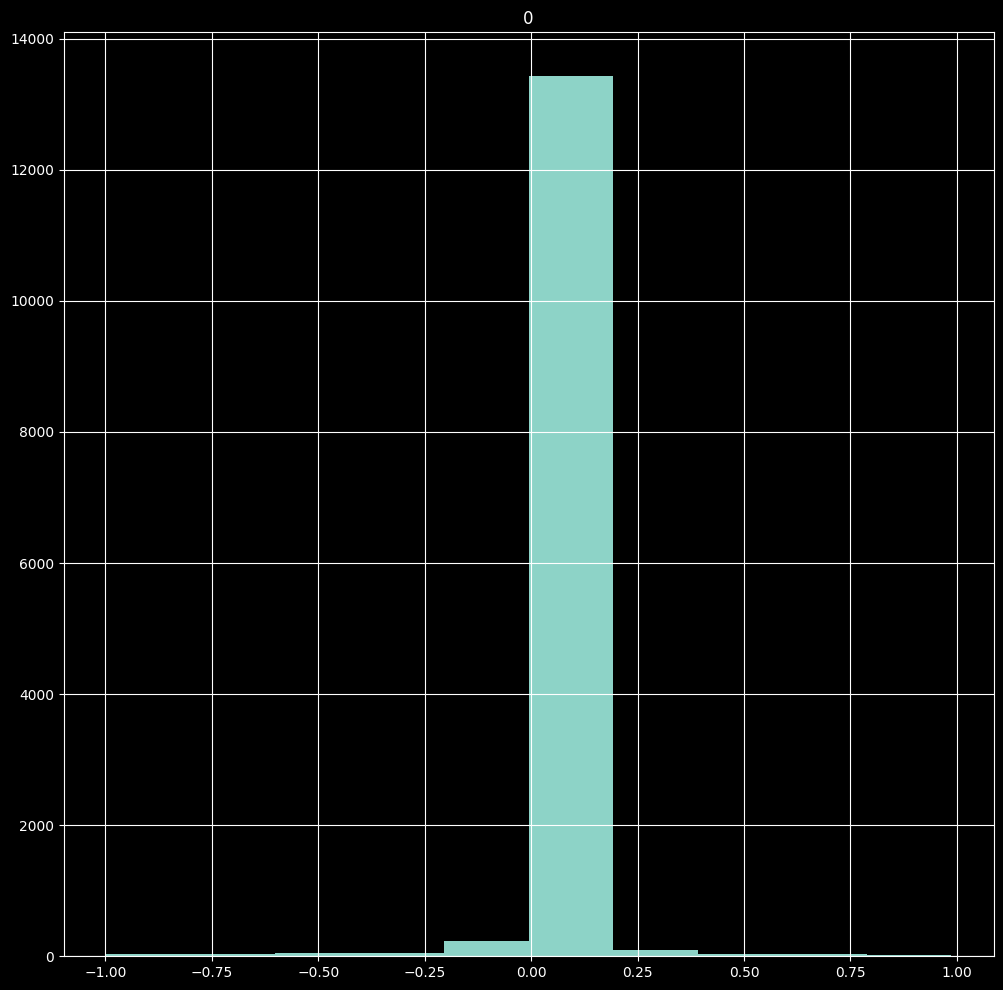

In [167]:
#смотрим на распределение переменной z
df1 = pd.DataFrame(z_train)
df1.hist()

### Конвертируем данные в тензор


In [197]:
train_XY = torch.from_numpy(xy_train).to(torch.float32)
train_Z = torch.from_numpy(z_train).type_as(train_XY)
val_XY = torch.from_numpy(xy_val).to(torch.float32)
val_Z = torch.from_numpy(z_val).type_as(val_XY)

In [198]:
test_XY = torch.from_numpy(xy_test).to(torch.float32)
test_Z = torch.from_numpy(z_test).type_as(test_XY)

## 3. Подготовка данных к обучению

In [199]:
BATCH = 100
# создали датасеты
train_dataset = TensorDataset(train_XY, train_Z)
val_dataset = TensorDataset(val_XY, val_Z)
test_dataset = TensorDataset(test_XY, test_Z)
# создаем загрузчики
train_loader = DataLoader(train_dataset, batch_size=BATCH)
val_loader = DataLoader(val_dataset, batch_size=BATCH)
test_loader = DataLoader(test_dataset, batch_size=BATCH)

In [200]:
DEVICE = "cpu"

## 4. Линейная модель аппроксимирующей функции



In [201]:
# как мы будем учиться работать с pyTorch
class NNsuperTest(nn.Module):
  # 1ый обязательный метод
  def __init__(self, in_features, out_features):
    super().__init__() # обязательно
    self.lin_linear_1 = self.make_layer(in_features, out_features)
    self.flatten = nn.Flatten(0, 1)
  #  self.relu = F.relu

  def make_layer(self, in_f, out_f):
    return nn.Linear(in_f, out_f)

  # 2ой обязательный метод
  def forward(self, x):
    x = self.lin_linear_1(x)
  #  x = self.relu(x)
    x = self.flatten(x)
    return x

## 5. Обучение

In [202]:
loss_fn = torch.nn.MSELoss(reduction='sum')

In [204]:
# подготовка
# 1. Задать модель - nn.Module
model = NNsuperTest(4, 1)
# 2. Задать функцию потерь - nn.NAME_OF_FUNC
#loss_function = nn.BCEWithLogitsLoss()
# 3. Задать оптимизатор - torch.optim.NAME_OF_OPTIM
#optimizer = torch.optim.SGD(model.parameters(), lr=.042)
#optimizer = torch.optim.SGD(model.parameters(), lr=.042)
# Будем использовать оптимайзер RMSprop из torch.optim:
optimizer = torch.optim.RMSprop(model.parameters(), lr=3e-4)
# поместить модель и метрику на GPU
model = model.to(DEVICE)
accuracy = Accuracy(task='binary',).to(DEVICE)
# создать вспомогательные списки для данных
# н-р, лосс на каждой итераций
losses_train = []
# н-р, общий лосс
total_loss = []
# н-р, accuracy
acc_val = []
# задать общее количество эпох
MAX_EPOCHS = 200
# для каждой эпохи
for epoch in tqdm(range(MAX_EPOCHS)):
  # для каждой части датасета
  for iteration, (X_batch, y_batch) in enumerate(train_loader):
    # ЭТАП ОБУЧЕНИЯ
    # мы переводим модель в режим обучения
    model.train()
    # ОБНУЛЯЕМ градиенты у оптимизатора
    optimizer.zero_grad()
    #model.zero_grad()
    # пропускам данные через модель
    outputs = model(X_batch.to(DEVICE))
    #print(f'1 outputs = {outputs}')
    # выравняем выходы в одномерный тензор
    #outputs = outputs.view(-1)
    outputs = outputs.unsqueeze(-1)
    #print(f'outputs = {outputs}')
   # print(f'y_batch = {y_batch}')
    # считаем лосс
    #loss = loss_function(outputs, y_batch.to(DEVICE))
    #loss = mse(y_batch.to(DEVICE), outputs)
    loss = loss_fn(outputs, y_batch.to(DEVICE))
    # делаем шаг в обратном направлении
    loss.backward()
    # собираем лоссы
    losses_train.append(loss.detach().cpu().numpy().item())
    # делаем шаг оптимизатора
    optimizer.step()
  # собираем средний лосс
  total_loss.append(np.mean(losses_train))
  # ШАГ ВАЛИДАЦИИ
  for iteration, (X_batch, y_batch) in enumerate(test_loader):
    # режим инференса или валидации, тестирования
    model.eval()
    # обязательно добавить
    with torch.no_grad():
      outputs = model(X_batch.to(DEVICE))
      #outputs = outputs.view(-1)
      outputs = outputs.unsqueeze(-1)
      #loss = loss_function(outputs, y_batch.to(DEVICE))
      loss = loss_fn(outputs, y_batch.to(DEVICE))
      # считаем вероятности
      proba = torch.sigmoid(outputs)
      # ситаем метрику
      batch_acc = accuracy(proba, y_batch.to(torch.int32).to(DEVICE))
      acc_val.append(batch_acc.detach().cpu().numpy().item())

  0%|          | 0/200 [00:00<?, ?it/s]

In [203]:
# запускать для отладки, когда необходимо почистить модель
with torch.no_grad():
  torch.cuda.empty_cache()

In [178]:
# Мы можем обратиться к первому слою нашей модели как к первому элементу list:
model.lin_linear_1

Linear(in_features=4, out_features=1, bias=True)

In [205]:
lin_linear_1 = model.lin_linear_1

### Cмотрим на коэффициенты функции, в том числе на смещение(bias)

In [206]:
lin_linear_1.bias.item()

0.004964825697243214

In [207]:
lin_linear_1.weight

Parameter containing:
tensor([[ 3.7756e-04,  2.2402e-05, -6.4704e-04, -4.4461e-05]],
       requires_grad=True)

In [208]:
# Печатаем значения весов этого слоя (это и будут обученный коэффициенты искомого полинома):
print(f'Result: z = {lin_linear_1.bias.item()} + {lin_linear_1.weight[:, 0].item()} * x + {lin_linear_1.weight[:, 1].item()} * x^2  + {lin_linear_1.weight[:, 2].item()} * y + {lin_linear_1.weight[:, 3].item()} * y^2')

Result: z = 0.004964825697243214 + 0.0003775577642954886 * x + 2.240212052129209e-05 * x^2  + -0.0006470389198511839 * y + -4.446056846063584e-05 * y^2


### Смотрим на MSE

In [209]:
acc = np.mean(acc_val)
print(f"Accuracy линейной модели {acc:.2%}")

Accuracy линейной модели 21.59%


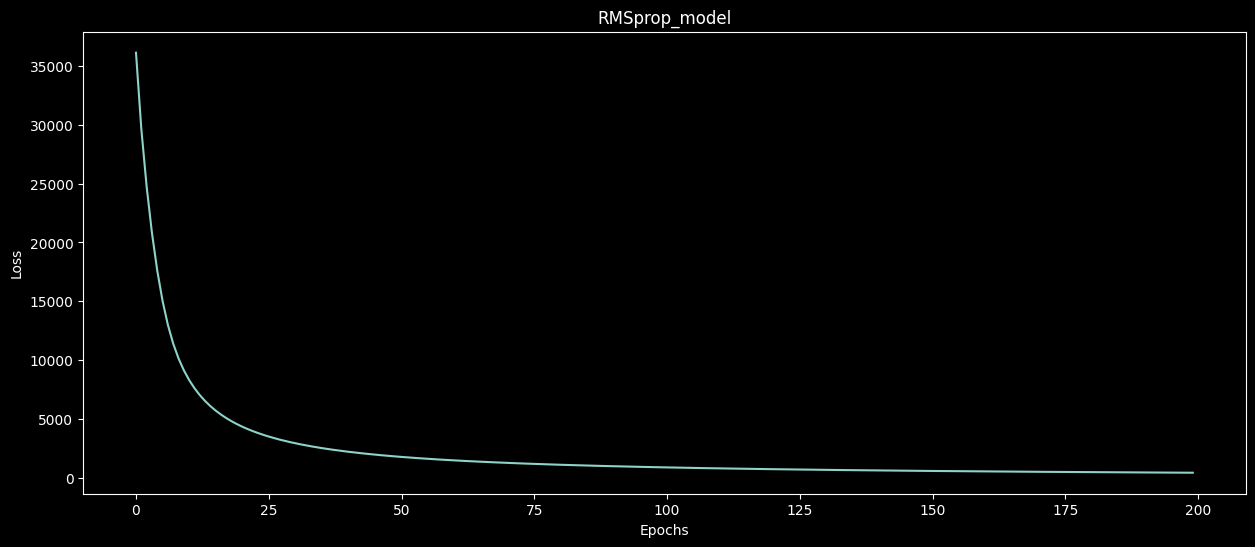

In [210]:
plt.figure(figsize=(15, 6))
plt.plot(range(len(total_loss)),
         total_loss,
         linestyle="-"
         )
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("RMSprop_model")
plt.show()

### Посмотрим на графике распределение всех данных

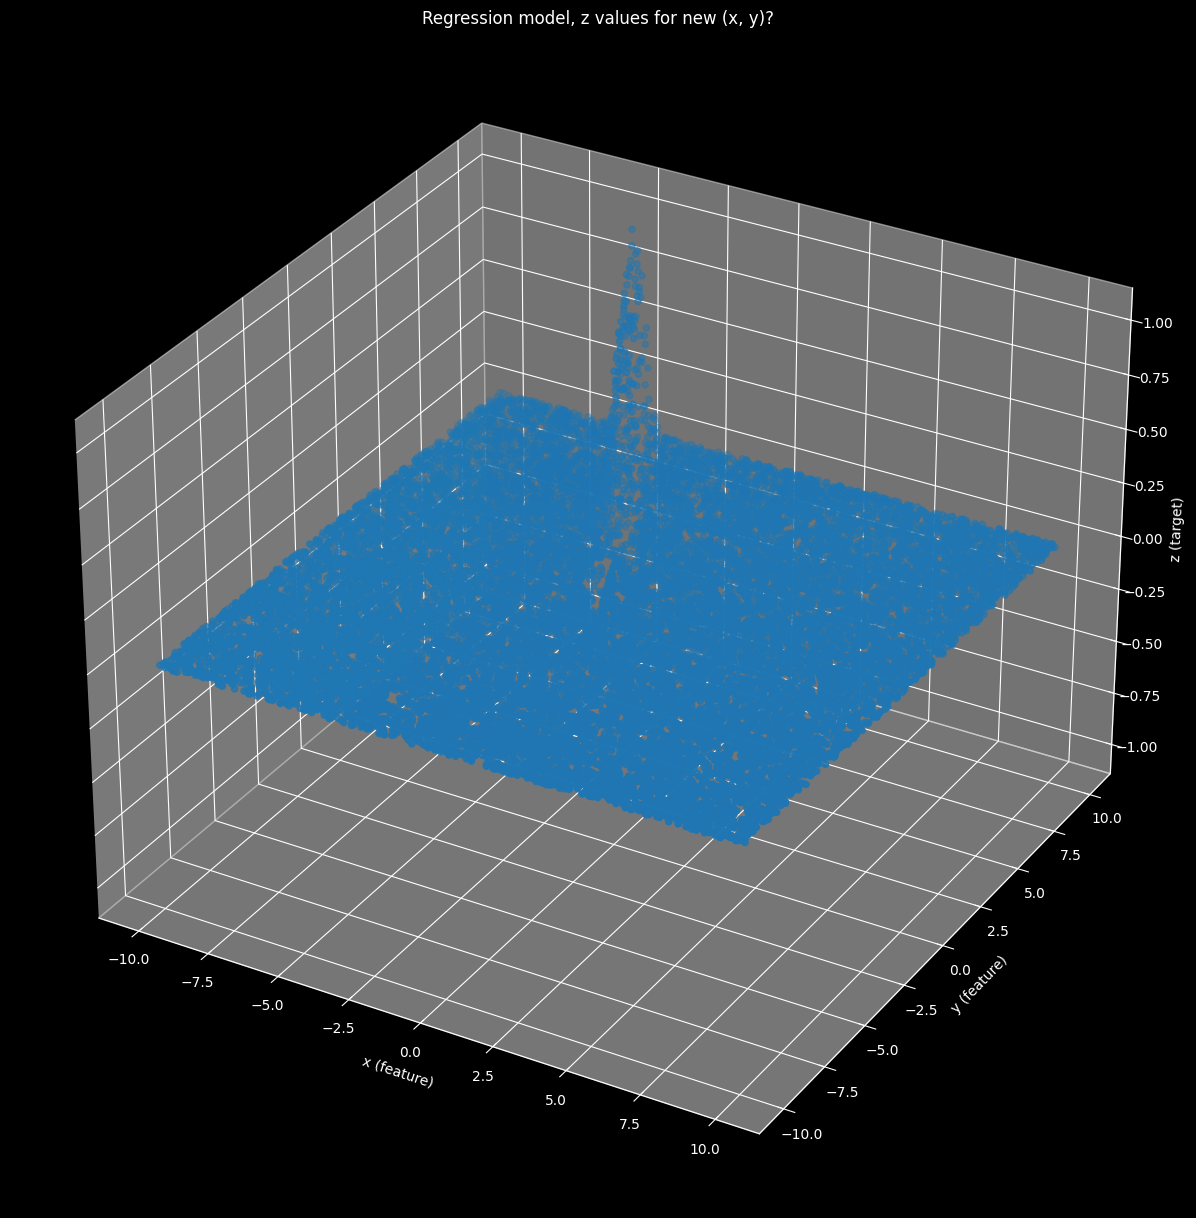

In [75]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = [12, 12]

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
ax.scatter(x_np, y_np, z_np, marker='o')

ax.set_title("Model, z values for new (x, y)?")
ax.set_xlabel("x (feature)")
ax.set_ylabel("y (feature)")
ax.set_zlabel("z (target)")

plt.show()

### График апроксимированной функции

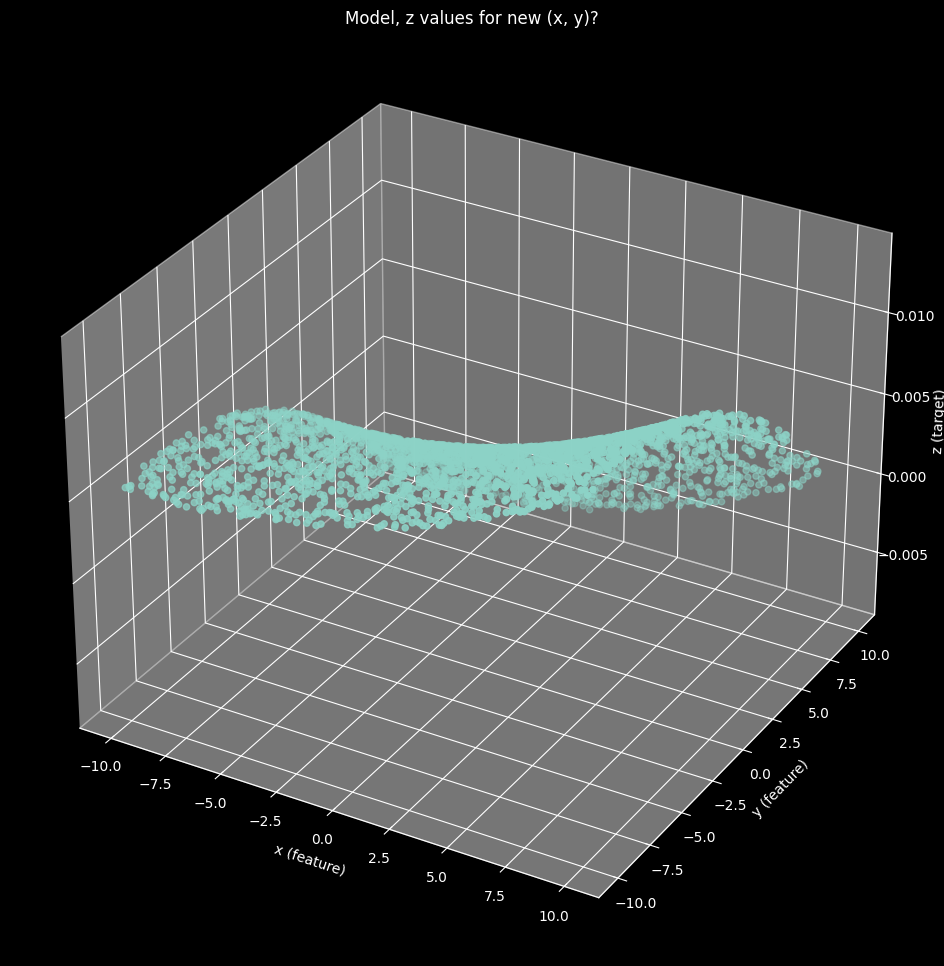

In [211]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams["figure.figsize"] = [12, 12]

z_res = lin_linear_1.bias.item() + (lin_linear_1.weight[:, 0].item())  * xy_test[:,0] + (lin_linear_1.weight[:, 1].item()) * xy_test[:,1]   + (lin_linear_1.weight[:, 2].item()) * xy_test[:,2] + (lin_linear_1.weight[:, 3].item()) * xy_test[:,3]

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

ax.scatter(xy_test[:,0], xy_test[:,2], z_res)

ax.set_title("Model, z values for new (x, y)?")
ax.set_xlabel("x (feature)")
ax.set_ylabel("y (feature)")
ax.set_zlabel("z (target)")

plt.show()

### График срвнения истинной функции и ее аппроксимированного варианта

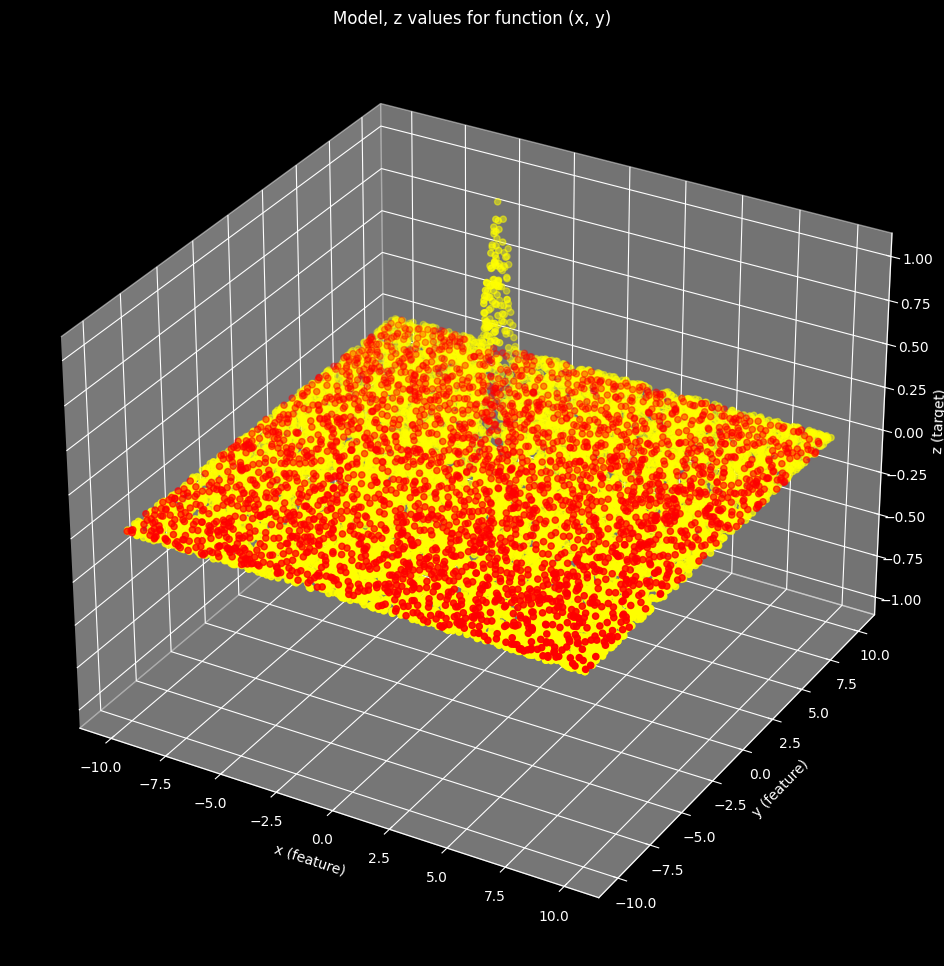

In [213]:
plt.rcParams["figure.figsize"] = [12, 12]
colors=["#0000FF", "#00FF00", "#FF0066"]

colors = {'Train data':'yellow', 'Test data':'red'}

key_train = 'Train data'
key_test = 'Test data'

fig, ax = plt.subplots(subplot_kw={"projection": "3d"})
#ax.scatter(x_np, y_np, z_np, marker='o', label='Australia', color=colors['Australia'])
ax.scatter(xy_train[:,0], xy_train[:,2], z_train, marker='o', label=key_train, color=colors[key_train])


z_test = lin_linear_1.bias.item() + (lin_linear_1.weight[:, 0].item())  * xy_test[:,0] + (lin_linear_1.weight[:, 1].item()) * xy_test[:,1]   + (lin_linear_1.weight[:, 2].item()) * xy_test[:,2] + (lin_linear_1.weight[:, 3].item()) * xy_test[:,3]

ax.scatter(xy_test[:,0], xy_test[:,2], z_test, label= key_test, color=colors[key_test])

ax.set_title("Model, z values for function (x, y)")
ax.set_xlabel("x (feature)")
ax.set_ylabel("y (feature)")
ax.set_zlabel("z (target)")

plt.show()

### Распределение z целевой функции на тренировочных данных

array([[<Axes: title={'center': '0'}>]], dtype=object)

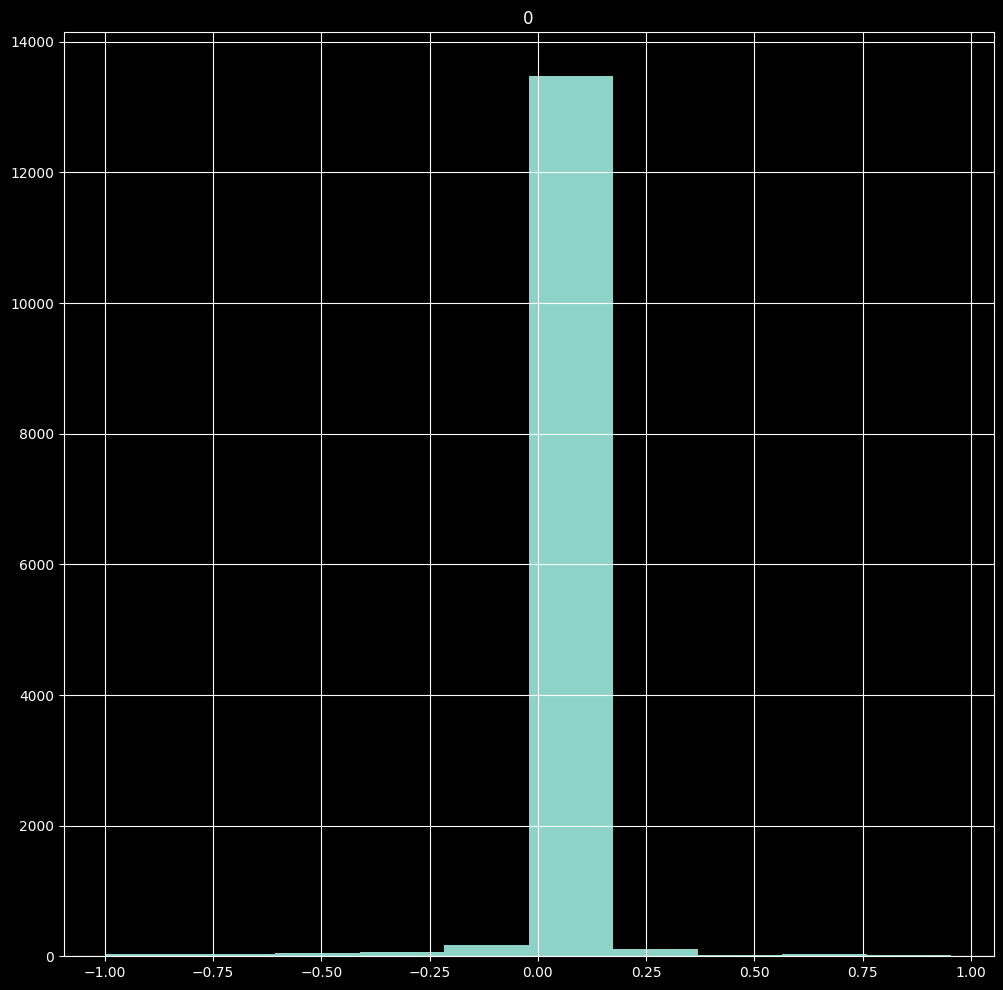

In [113]:

df1 = pd.DataFrame(z_train)
df1.hist()

### Распределение z на полученных данных через аппроксимированную функцию

array([[<Axes: title={'center': '0'}>]], dtype=object)

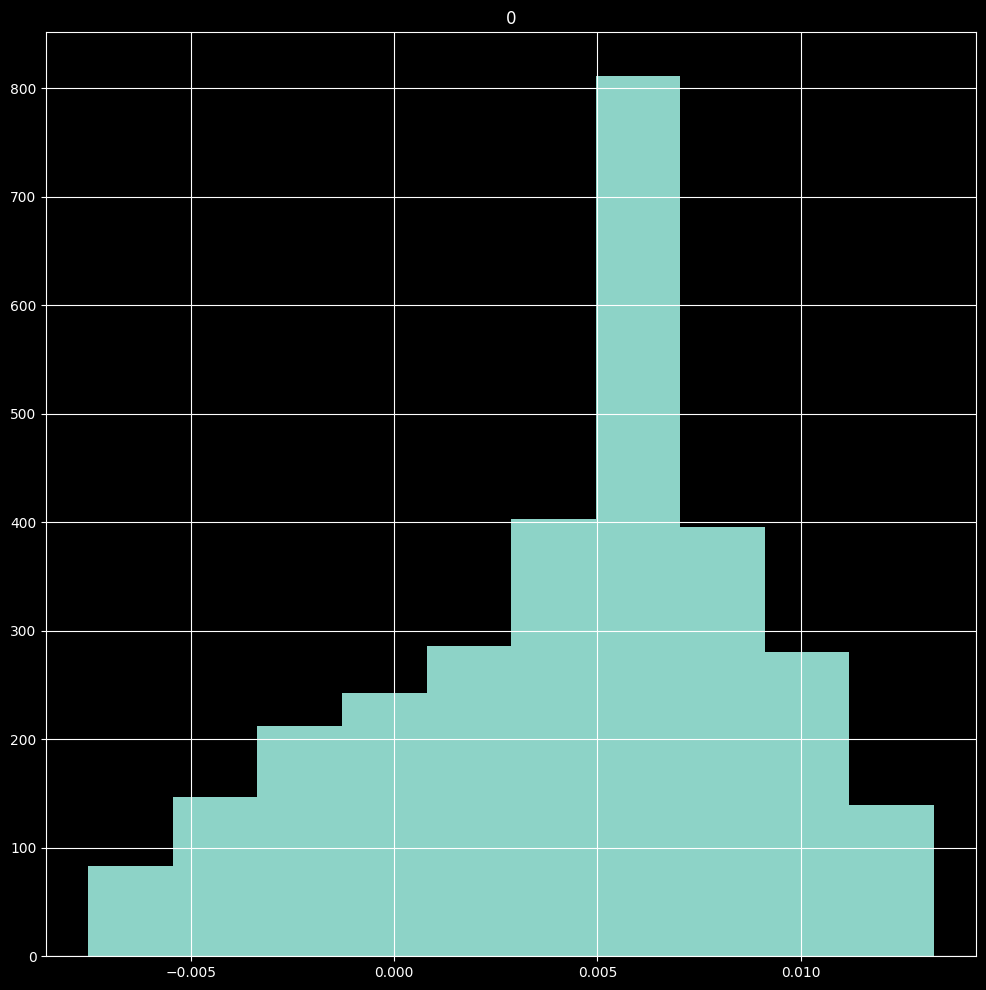

In [217]:
df2 = pd.DataFrame(z_res)
df2.hist()

In [165]:
z_res

array([ 0.70122008,  2.14858756, -3.68706533, ..., -1.73994802,
       -5.35906473, -4.44080467])

### Чистим кэш модели  от градиентов

In [221]:
with torch.no_grad():
  torch.cuda.empty_cache()